In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [16]:
ratio_th = 0.95

In [17]:
# Load images
img_color_1 = cv2.imread('spy1.jpg')
img_color_2 = cv2.imread('spy2.jpg')


img1 = cv2.cvtColor(img_color_1, cv2.COLOR_BGR2YCrCb)[:,:,0]
img2 = cv2.cvtColor(img_color_2, cv2.COLOR_BGR2YCrCb)[:,:,0]

# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Create a matcher
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < ratio_th * n.distance:
        good_matches.append(m)

if len(good_matches) == 0:
    print("Not eough good matches")
    raise SystemExit()
# Draw matches on images
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
cv2.namedWindow('Initially found matches', cv2.WINDOW_NORMAL)
cv2.imshow('Initially found matches', img_matches)


In [18]:
# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Use RANSAC to estimate the transformation matrix
transformation_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

print(transformation_matrix)
# Draw matches on images excluding outliers
good_matches_outlier_removed = np.array(good_matches)[mask.ravel() == 1]
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, 
                              good_matches_outlier_removed, 
                              None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
win = cv2.namedWindow('Matches after reprojection iterations', cv2.WINDOW_NORMAL)
cv2.imshow('Matches after reprojection iterations', img_matches)


# Apply the transformation to image1
registered_img_color_1 = cv2.warpPerspective(img_color_1, transformation_matrix, (img_color_2.shape[1], img_color_2.shape[0]))

# Display the results
cv2.namedWindow('Registered Image 1', cv2.WINDOW_NORMAL)
cv2.imshow('Registered Image 1', registered_img_color_1)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 1.07062913e+00  1.64185216e-01  1.17178225e+02]
 [-6.89350664e-01  3.06729720e+00 -2.44633753e+02]
 [-9.98968244e-04  2.48346570e-03  1.00000000e+00]]


# Combined approach

## Croping based on most external keypoints

In [19]:
# np.array([kps_des_list[i]['kps'][m.queryIdx].pt for m in masked_matches_list[i]], dtype='float')

good_kps2_pt = np.array([keypoints2[m.trainIdx].pt for m in good_matches_outlier_removed])
print(len(keypoints2), good_kps2_pt.shape, len(good_matches))
bbox = (np.array([np.min(good_kps2_pt[:,1]), np.min(good_kps2_pt[:,0])], dtype=int),
        np.array([np.max(good_kps2_pt[:,1]), np.max(good_kps2_pt[:,0])], dtype=int)) # (x, y) = (column, row)
bbox

902 (21, 2) 370


(array([155, 161]), array([364, 346]))

## Display cropped images

In [20]:
registered_img_color_1_bbox = cv2.rectangle(registered_img_color_1.copy(), bbox[0][::-1], bbox[1][::-1], color=(0, 255, 0))
img_color_2_bbox = cv2.rectangle(img_color_2.copy(), bbox[0][::-1], bbox[1][::-1], color=(0, 255, 0))
# cv2.imshow('Registered Image 1', registered_img_color_1_bbox)
# cv2.imshow('Original Image 2', img_color_2_bbox)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

registered_img_color_1_cropped = registered_img_color_1_bbox[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
img_color_2_cropped = img_color_2_bbox[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :]
cv2.namedWindow('Registered Image 1', cv2.WINDOW_KEEPRATIO)
cv2.namedWindow('Original Image 2', cv2.WINDOW_KEEPRATIO)
cv2.imshow('Registered Image 1', registered_img_color_1_cropped)
cv2.imshow('Original Image 2', img_color_2_cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Convert to luminance-chrominance

In [21]:
im1_comp = cv2.cvtColor(registered_img_color_1_cropped, cv2.COLOR_BGR2YCrCb).astype(float)/255
im2_comp = cv2.cvtColor(img_color_2_cropped, cv2.COLOR_BGR2YCrCb).astype(float)/255
decimation_factor = 4


### Comparison of histograms

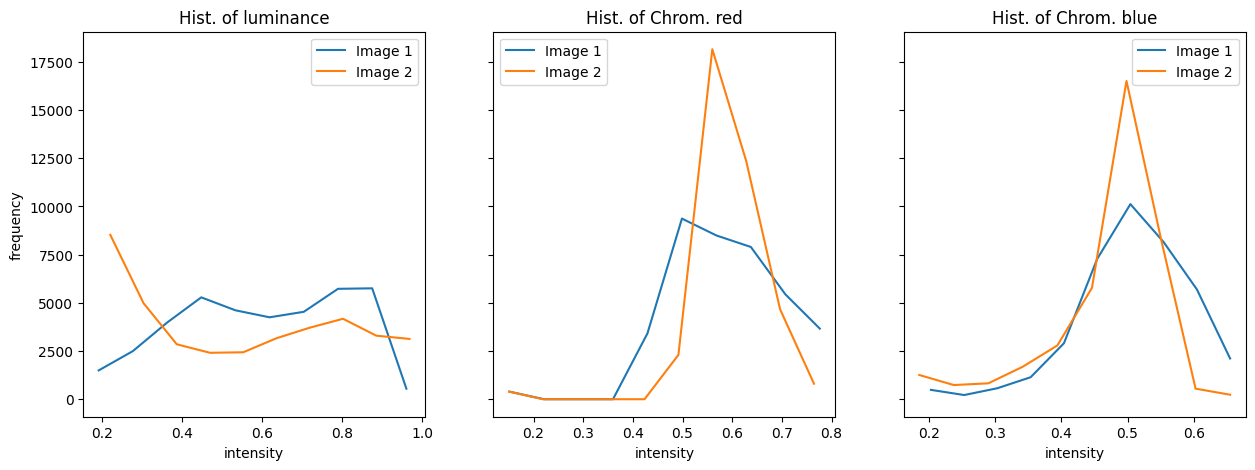

In [22]:
# histogram
hist1 = [np.histogram(im1_comp[:,:,i]) for i in range(3)] # The histogram is computed over the flattened array.
hist2 = [np.histogram(im2_comp[:,:,i]) for i in range(3)]

fig, ax = plt.subplots(1,3, sharey='row', figsize=[15, 5])
titles = ['Hist. of luminance', 'Hist. of Chrom. red', 'Hist. of Chrom. blue']
ax[0].set_ylabel('frequency')
for i in range(3):
    ax[i].plot(hist1[i][1][1:], hist1[i][0], label='Image 1')
    ax[i].plot(hist2[i][1][1:], hist2[i][0], label='Image 2')
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('intensity')
    ax[i].legend()
plt.show()

### Correlation in luminance

In [23]:
corr_Y = (im1_comp[::decimation_factor,::decimation_factor,0]-0.5)*(im2_comp[::decimation_factor,::decimation_factor,0]-0.5)
corr_Y += np.min(corr_Y)
corr_Y /= np.max(corr_Y)
cv2.namedWindow('Image 1', cv2.WINDOW_FREERATIO)
cv2.namedWindow('Image 2', cv2.WINDOW_FREERATIO)
cv2.namedWindow('Y correlation', cv2.WINDOW_FREERATIO)

cv2.imshow('Image 1', im1_comp[:,:,0])
cv2.imshow('Image 2', im2_comp[:,:,0])
cv2.imshow('Y correlation', corr_Y)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Correlation in chorminance red

In [ ]:
corr_red = (im1_comp[::decimation_factor,::decimation_factor,1]-0.5)*(im2_comp[::decimation_factor,::decimation_factor,1]-0.5)
corr_red += np.min(corr_red)
corr_red /= np.max(corr_red)
cv2.namedWindow('Image 1', cv2.WINDOW_FREERATIO)
cv2.namedWindow('Image 2', cv2.WINDOW_FREERATIO)
cv2.namedWindow('Chrome red correlation', cv2.WINDOW_FREERATIO)

cv2.imshow('Image 1', im1_comp[:,:,1])
cv2.imshow('Image 2', im2_comp[:,:,1])
cv2.imshow('Chrome red correlation', corr_red)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Correlation in chrominance blue (e.g. spyder logo)

In [ ]:
corr_blue = (im1_comp[::decimation_factor,::decimation_factor,2]-0.5)*(im2_comp[::decimation_factor,::decimation_factor,2]-0.5)
corr_blue += np.min(corr_blue)
corr_blue /= np.max(corr_blue)
cv2.namedWindow('Image 1', cv2.WINDOW_FREERATIO)
cv2.namedWindow('Image 2', cv2.WINDOW_FREERATIO)
cv2.namedWindow('Chrome blue correlation', cv2.WINDOW_FREERATIO)

cv2.imshow('Image 1', im1_comp[:,:,2])
cv2.imshow('Image 2', im2_comp[:,:,2])
cv2.imshow('Chrome blue correlation', corr_blue)
cv2.waitKey(0)
cv2.destroyAllWindows()